# Soial Media Sentiment Analysis

## Import libraries

In [ ]:
!pip install -qq transformers

In [ ]:
!pip install --upgrade transformers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from wordcloud import WordCloud

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

from sklearn.preprocessing import LabelEncoder

#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from collections import defaultdict

from tqdm import tqdm


import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Data Overview

In [ ]:
file_path = '/content/sentimentdataset.csv'
df = pd.read_csv(file_path)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  732 non-null    int64  
 1   Unnamed: 0    732 non-null    int64  
 2   Text          732 non-null    object 
 3   Sentiment     732 non-null    object 
 4   Timestamp     732 non-null    object 
 5   User          732 non-null    object 
 6   Platform      732 non-null    object 
 7   Hashtags      732 non-null    object 
 8   Retweets      732 non-null    float64
 9   Likes         732 non-null    float64
 10  Country       732 non-null    object 
 11  Year          732 non-null    int64  
 12  Month         732 non-null    int64  
 13  Day           732 non-null    int64  
 14  Hour          732 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 85.9+ KB


732 entries, not a large dataset

In [ ]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


## Data Cleaning

Notice two columns are missing appropirate labels, need to label all columns with meanings and drop duplicate ones.

In [ ]:
# rename columns 'unamed' to 'id'
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
# drop remaining column 'unamed: 0.1'
df.drop(columns=['Unnamed: 0.1'], inplace=True)
# reset index as column 'id'
df.set_index('id', inplace=True)

In [ ]:
df.head()

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
id,,,,,,,,,,,,,
0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [ ]:
# check for missing values
df.isnull().sum()

,0
Text,0
Sentiment,0
Timestamp,0
User,0
Platform,0
Hashtags,0
Retweets,0
Likes,0
Country,0
Year,0


NULL check: no NULL value

In [ ]:
# check for duplicates
df.duplicated().sum()

np.int64(20)

Duplicate check: 20 duplicate values, need to eliminate

In [ ]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 0 to 736
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Text       712 non-null    object 
 1   Sentiment  712 non-null    object 
 2   Timestamp  712 non-null    object 
 3   User       712 non-null    object 
 4   Platform   712 non-null    object 
 5   Hashtags   712 non-null    object 
 6   Retweets   712 non-null    float64
 7   Likes      712 non-null    float64
 8   Country    712 non-null    object 
 9   Year       712 non-null    int64  
 10  Month      712 non-null    int64  
 11  Day        712 non-null    int64  
 12  Hour       712 non-null    int64  
dtypes: float64(2), int64(4), object(7)
memory usage: 77.9+ KB


In [ ]:
# make sure all timestamps are in datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
# create a col to find out the day of the week for each timestamp
df['Day_of_Week'] = df['Timestamp'].dt.day_name()
df['Month'] = df['Timestamp'].dt.month_name()

In [ ]:
df['Country'].value_counts()

,count
Country,
USA,59
USA,51
UK,49
Canada,44
Australia,36
...,...
Ireland,1
Scotland,1
Kenya,1


USA is counted twice, need to trim for accuracy

In [ ]:
# convert all texts to lowercase & strip the white spaces in the 'Platform' column
df['Country'] = df['Country'].str.lower()
df['Country'] = df['Country'].str.strip()
df['Country'].value_counts()

,count
Country,
usa,184
uk,140
canada,132
australia,70
india,68
brazil,17
france,16
japan,15
germany,14


In [ ]:
# convert all texts to lowercase & strip the white spaces in the 'Platform' column
df['Platform'] = df['Platform'].str.lower()
df['Platform'] = df['Platform'].str.strip()
df['Platform'].value_counts()

,count
Platform,
instagram,252
twitter,236
facebook,224


In [ ]:
# list out all sentiments
pd.set_option('display.max_rows', None)
df['Sentiment'].value_counts()

,count
Sentiment,
Positive,44
Joy,42
Excitement,32
Neutral,14
Happy,14
Contentment,13
Gratitude,9
Sad,9
Curiosity,8


Noticed some sentiments are counted twice, need to trim data for accuracy

In [ ]:
# convert all texts to lowercase & strip the white spaces in the 'Sentiment' column
df['Sentiment'] = df['Sentiment'].str.lower()
df['Sentiment'] = df['Sentiment'].str.strip()
df['Sentiment'].value_counts().shape

(191,)

Now there are over 190 distinct sentiments in our dataset.

In [ ]:
# count the top 10 most frequent words in the 'Sentiment' column
pd.set_option('display.max_rows', None)
df['Sentiment'].value_counts()

,count
Sentiment,
positive,45
joy,44
excitement,37
contentment,18
neutral,18
gratitude,17
curiosity,16
serenity,15
happy,14


Text(0.5, 1.0, 'Top 10 sentiments on Social Media')

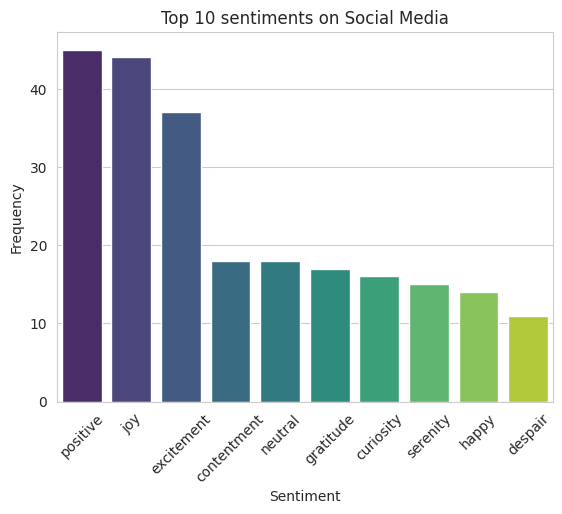

In [ ]:
# Visualize the top 10 most frequent words in the 'Sentiment' column, and order by frequency in descending order
sns.set_style('whitegrid')
sns.countplot(x='Sentiment', data=df, order=df['Sentiment'].value_counts().index[:10], palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Top 10 sentiments on Social Media')

There are over 190 sentiments in total, and top sentiments include: positive, joy, excitement....

In [28]:
df1 = df.copy()

In [29]:
# preprocess text by removing punctuation(other than ? and ! and emojis), stopwords, and converting all texts to lowercase
# define punctuation and stopwords
punctuation = '"#$%&\'()*+,-./:;<=>@[\\]^_`{|}~'
# nltk's stopwords can be found @ https://gist.github.com/sebleier/554280
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
# ensure all values in the 'Text' column are strings
df1['Text'] = df1['Text'].astype(str)

# remove punctuation (except '?' and '!'), convert to lowercase, and remove stopwords
df1['Cleaned_Text'] = df1['Text'].apply(lambda x: re.sub(f"[{re.escape(punctuation)}]", '', x).lower())
df1['Cleaned_Text'] = df1['Cleaned_Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
df1['Cleaned_Text'].head()

,Cleaned_Text
id,
0,enjoying beautiful day park!
1,traffic terrible morning
2,finished amazing workout! 💪
3,excited upcoming weekend getaway!
4,trying new recipe dinner tonight


In [30]:
df1['Temp_List'] = df1['Cleaned_Text'].apply(lambda x: str(x).split())

In [31]:
df2 = df1.copy()
df2.head()

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,Day_of_Week,Cleaned_Text,Temp_List
id,,,,,,,,,,,,,,,,
0,Enjoying a beautiful day at the park! ...,positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,January,15,12,Sunday,enjoying beautiful day park!,"[enjoying, beautiful, day, park!]"
1,Traffic was terrible this morning. ...,negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,January,15,8,Sunday,traffic terrible morning,"[traffic, terrible, morning]"
2,Just finished an amazing workout! 💪 ...,positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,January,15,15,Sunday,finished amazing workout! 💪,"[finished, amazing, workout!, 💪]"
3,Excited about the upcoming weekend getaway! ...,positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,January,15,18,Sunday,excited upcoming weekend getaway!,"[excited, upcoming, weekend, getaway!]"
4,Trying out a new recipe for dinner tonight. ...,neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,January,15,19,Sunday,trying new recipe dinner tonight,"[trying, new, recipe, dinner, tonight]"


In [32]:
df2 = df2.groupby('Sentiment').filter(lambda x: len(x) >= 5)
df2['Sentiment'].value_counts()

,count
Sentiment,
positive,45
joy,44
excitement,37
contentment,18
neutral,18
gratitude,17
curiosity,16
serenity,15
happy,14


In [33]:
X = df2['Cleaned_Text']
y = df2['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=52)

In [35]:
# word embedding usinf TfidfVectorizer
# create a TfidfVectorizer object
tfidf = TfidfVectorizer()
# fit and transform the training data
X_train_tfidf = tfidf.fit_transform(X_train)
# transform the test data
X_test_tfidf = tfidf.transform(X_test)

In [36]:
X_train_tfidf.shape, X_test_tfidf.shape

((352, 1494), (89, 1494))

In [37]:
# create a SVC object
svm_classifier = LinearSVC(random_state=42)
svm_classifier.fit(X_train_tfidf, y_train)
# predict the test data
y_pred = svm_classifier.predict(X_test_tfidf)
print("Support Vector Machine Results:")
print(f"Accuracy: {round(svm_classifier.score(X_test_tfidf, y_test),4)}")
print("Classification Report:\n", classification_report(y_test, y_pred))# create a SVC object
svm_classifier = LinearSVC(random_state=42)
svm_classifier.fit(X_train_tfidf, y_train)
# predict the test data
y_pred = svm_classifier.predict(X_test_tfidf)
print("Support Vector Machine Results:")
print(f"Accuracy: {round(svm_classifier.score(X_test_tfidf, y_test),4)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Support Vector Machine Results:
Accuracy: 0.573
Classification Report:
                precision    recall  f1-score   support

   acceptance       0.00      0.00      0.00         0
  ambivalence       1.00      1.00      1.00         1
          bad       1.00      0.50      0.67         2
     betrayal       0.00      0.00      0.00         0
   bitterness       1.00      0.50      0.67         2
    confusion       0.67      1.00      0.80         2
  contentment       1.00      0.25      0.40         4
    curiosity       0.67      0.67      0.67         3
      despair       1.00      1.00      1.00         4
determination       1.00      1.00      1.00         1
      disgust       1.00      1.00      1.00         2
  embarrassed       0.00      0.00      0.00         1
  empowerment       0.00      0.00      0.00         1
   enthusiasm       1.00      0.50      0.67         2
     euphoria       1.00      1.00      1.00         1
   excitement       0.33      0.40      0.36   

## NLP Text-Sentiment Analysis using distilBERT

### Data Selection

In [ ]:
df4 = df1.copy()
top_sentiments = df4['Sentiment'].value_counts()[df4['Sentiment'].value_counts() >= 5].index
# df4 = df4[df4['Sentiment'].isin(top_10_sentiment)]
df4.loc[~df4['Sentiment'].isin(top_sentiments), 'Sentiment'] = 'miscellaneous'
df4['Sentiment'].value_counts()

,count
Sentiment,
miscellaneous,271
positive,45
joy,44
excitement,37
contentment,18
neutral,18
gratitude,17
curiosity,16
serenity,15


In [ ]:
# label encoding all selected sentiments
le = LabelEncoder()
df4['Sentiment'] = le.fit_transform(df4['Sentiment'])
df4['Sentiment'].value_counts().shape

(42,)

### Text Tokenization

In [ ]:
# load pre-trained model & tokenizer
PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [ ]:
# use sample text for tokenization
sample_txt = 'Enjoying a beautiful day at the park!'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Enjoying a beautiful day at the park!
   Tokens: ['enjoying', 'a', 'beautiful', 'day', 'at', 'the', 'park', '!']
Token IDs: [9107, 1037, 3376, 2154, 2012, 1996, 2380, 999]


In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
token_lens = []

for txt in df4.Cleaned_Text:
  #tokenizing the text
      tokens = tokenizer.encode(txt, max_length=512)
      token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

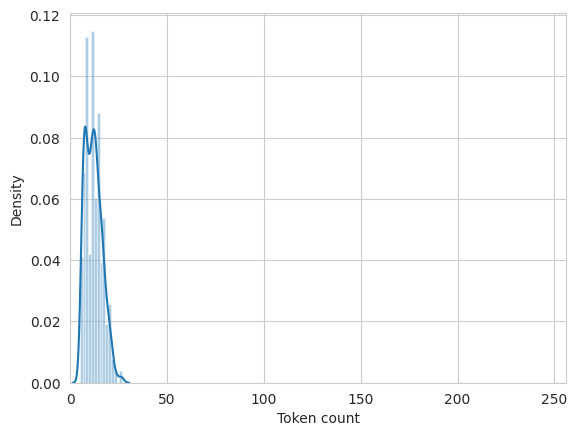

In [ ]:
# visualize token counts
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [ ]:
selected_columns = ['Cleaned_Text', 'Sentiment']
df4 = df4[selected_columns]
df4.head()

,Cleaned_Text,Sentiment
id,,
0,enjoying beautiful day park!,36
1,traffic terrible morning,32
2,finished amazing workout! 💪,36
3,excited upcoming weekend getaway!,36
4,trying new recipe dinner tonight,33


In [ ]:
# set up fixed length for each inputs
MAX_LEN = 50

### Data Preparation for PyTorch

In [ ]:
# preprocess current df to dataset in pytorch
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    # Tokenization: The tokenizer.encode_plus method ensures the text is converted into a format suitable for transformer models.
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
    # Padding and Truncation: Handles variable-length sequences by padding or truncating to a fixed length
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    # Returns data as PyTorch tensors
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
# split data again for training, evaluation, testing
df4_train, df4_test = train_test_split(df4, test_size=0.30, shuffle=True)
df4_val, df4_test = train_test_split(df4_test, test_size=0.50,shuffle=True)

In [ ]:
# batch the preprocessed torch dataset and prepare it for model training
def create_data_loader(df4, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df4.Cleaned_Text.to_numpy(),
    targets=df4.Sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,

  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
  )

In [ ]:
df4_train.shape, df4_val.shape, df4_test.shape

((498, 2), (107, 2), (107, 2))

In [ ]:
BATCH_SIZE = 8
# convert df to dataset(tensor) for pytorch
train_data_loader = create_data_loader(df4_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df4_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df4_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 50])
torch.Size([8, 50])
torch.Size([8])


### Model Building

In [ ]:
# import pre-trained model from bert
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
last_hidden_state = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [ ]:
PRE_TRAINED_MODEL_NAME

'distilbert-base-uncased'

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
# Build a sentiment classfier on BERT by orchestrating DL layers & defining output
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)  # model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )

        # Assuming logits are in the first element of the tuple
        logits = outputs[0]

        # Apply dropout and linear layer
        output = self.drop(logits)

        # Assuming you want to use the representation for the [CLS] token
        cls_representation = logits[:, 0, :]

        return self.out(cls_representation)

In [ ]:
# can use cpu since it is a small dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# instantite a sentiment classifier model
model = SentimentClassifier(42)
model = model.to(device)

In [ ]:
model

SentimentClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Lin

In [ ]:
# load input & attention_mask
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 50])
torch.Size([8, 50])


In [ ]:
# use softmax for output simulation(no representation)
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.0282, 0.0321, 0.0286, 0.0218, 0.0303, 0.0250, 0.0205, 0.0149, 0.0205,
         0.0256, 0.0273, 0.0217, 0.0251, 0.0277, 0.0498, 0.0218, 0.0193, 0.0209,
         0.0237, 0.0268, 0.0219, 0.0264, 0.0405, 0.0270, 0.0256, 0.0213, 0.0176,
         0.0157, 0.0238, 0.0173, 0.0220, 0.0191, 0.0208, 0.0207, 0.0148, 0.0246,
         0.0230, 0.0195, 0.0137, 0.0305, 0.0253, 0.0175],
        [0.0242, 0.0373, 0.0374, 0.0199, 0.0308, 0.0261, 0.0180, 0.0168, 0.0252,
         0.0204, 0.0281, 0.0281, 0.0298, 0.0259, 0.0532, 0.0216, 0.0159, 0.0191,
         0.0265, 0.0289, 0.0171, 0.0254, 0.0308, 0.0269, 0.0224, 0.0236, 0.0221,
         0.0178, 0.0256, 0.0139, 0.0197, 0.0157, 0.0194, 0.0221, 0.0147, 0.0260,
         0.0192, 0.0195, 0.0131, 0.0312, 0.0213, 0.0189],
        [0.0291, 0.0297, 0.0329, 0.0229, 0.0345, 0.0258, 0.0215, 0.0147, 0.0221,
         0.0237, 0.0272, 0.0253, 0.0238, 0.0258, 0.0498, 0.0196, 0.0163, 0.0182,
         0.0255, 0.0292, 0.0184, 0.0243, 0.0362, 0.0278, 0.0253, 0.0184, 0

### Model Training

In [ ]:
# set up hyperparameter for training
EPOCHS = 20

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=4,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device) # use crossrntropy for text classification

In [ ]:
# define training model
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0

    # tqdm for progress monitoring (visualization)
    data_loader = tqdm(data_loader, desc="Training", unit="batch")

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].squeeze().to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Update tqdm description with the current loss
        data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# define evaluation model
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0


    data_loader = tqdm(data_loader, desc="Evaluating", unit="batch")

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            # Ensure targets are of type long
            targets = targets.view(-1)  # Reshape to a 1-dimensional tensor if needed
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            # Update tqdm description with the current loss
            data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df4_train)
  )

  print(f'\nTrain loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df4_val)
  )

  print(f'\nVal   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  # if val_acc > best_accuracy:
  #   torch.save(model.state_dict(), 'best_model_state.bin')
  #   best_accuracy = val_acc

Epoch 1/20
----------


Training: 100%|██████████| 63/63 [01:28<00:00,  1.41s/batch, loss=2.9] 



Train loss 2.9000898599624634 accuracy 0.3614457831325301


Evaluating: 100%|██████████| 14/14 [00:05<00:00,  2.69batch/s, loss=2.75]



Val   loss 2.75253073658262 accuracy 0.35514018691588783

Epoch 2/20
----------


Training: 100%|██████████| 63/63 [01:30<00:00,  1.44s/batch, loss=2.5] 



Train loss 2.5005552163199773 accuracy 0.44779116465863456


Evaluating: 100%|██████████| 14/14 [00:04<00:00,  2.98batch/s, loss=2.5] 



Val   loss 2.497792286532266 accuracy 0.38317757009345793

Epoch 3/20
----------


Training: 100%|██████████| 63/63 [01:28<00:00,  1.41s/batch, loss=1.9] 



Train loss 1.9001204011932251 accuracy 0.5441767068273092


Evaluating: 100%|██████████| 14/14 [00:04<00:00,  2.84batch/s, loss=2.25]



Val   loss 2.2467316601957594 accuracy 0.4672897196261682

Epoch 4/20
----------


Training: 100%|██████████| 63/63 [01:29<00:00,  1.43s/batch, loss=1.15]



Train loss 1.1542376459590973 accuracy 0.7369477911646586


Evaluating: 100%|██████████| 14/14 [00:04<00:00,  2.97batch/s, loss=1.85]



Val   loss 1.847710166658674 accuracy 0.6074766355140186

Epoch 5/20
----------


Training: 100%|██████████| 63/63 [01:29<00:00,  1.42s/batch, loss=0.629]



Train loss 0.6285644831165434 accuracy 0.9016064257028112


Evaluating: 100%|██████████| 14/14 [00:05<00:00,  2.65batch/s, loss=1.54]



Val   loss 1.5395094071115767 accuracy 0.6542056074766355

Epoch 6/20
----------


Training: 100%|██████████| 63/63 [01:47<00:00,  1.71s/batch, loss=0.341]



Train loss 0.34137044267521965 accuracy 0.9678714859437751


Evaluating: 100%|██████████| 14/14 [00:04<00:00,  2.89batch/s, loss=1.72]



Val   loss 1.7205923242228371 accuracy 0.6074766355140186

Epoch 7/20
----------


Training: 100%|██████████| 63/63 [01:31<00:00,  1.46s/batch, loss=0.2]  



Train loss 0.19988793091818927 accuracy 0.9899598393574297


Evaluating: 100%|██████████| 14/14 [00:05<00:00,  2.78batch/s, loss=1.48]



Val   loss 1.4830942835126604 accuracy 0.7102803738317757

Epoch 8/20
----------


Training: 100%|██████████| 63/63 [01:30<00:00,  1.44s/batch, loss=0.12] 



Train loss 0.11984307553973936 accuracy 0.9979919678714859


Evaluating: 100%|██████████| 14/14 [00:04<00:00,  2.86batch/s, loss=1.44]



Val   loss 1.4412609721933092 accuracy 0.6822429906542056

Epoch 9/20
----------


Training: 100%|██████████| 63/63 [01:31<00:00,  1.45s/batch, loss=0.0879]



Train loss 0.08787885824188826 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:05<00:00,  2.70batch/s, loss=1.51]



Val   loss 1.5149853697844915 accuracy 0.7102803738317757

Epoch 10/20
----------


Training: 100%|██████████| 63/63 [01:30<00:00,  1.44s/batch, loss=0.0726]



Train loss 0.07261021130733074 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:05<00:00,  2.77batch/s, loss=1.42]



Val   loss 1.4197226182690688 accuracy 0.7102803738317757

Epoch 11/20
----------


Training: 100%|██████████| 63/63 [01:31<00:00,  1.46s/batch, loss=0.0597]



Train loss 0.05969181857884876 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:04<00:00,  2.88batch/s, loss=1.49]



Val   loss 1.4854995118720191 accuracy 0.719626168224299

Epoch 12/20
----------


Training: 100%|██████████| 63/63 [01:48<00:00,  1.73s/batch, loss=0.0529]



Train loss 0.052925105812767194 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:05<00:00,  2.36batch/s, loss=1.38]



Val   loss 1.384393362062318 accuracy 0.7102803738317757

Epoch 13/20
----------


Training: 100%|██████████| 63/63 [01:32<00:00,  1.46s/batch, loss=0.0473]



Train loss 0.047338099204122075 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:05<00:00,  2.34batch/s, loss=1.34]



Val   loss 1.3418534312929427 accuracy 0.7102803738317757

Epoch 14/20
----------


Training: 100%|██████████| 63/63 [01:34<00:00,  1.50s/batch, loss=0.0429]



Train loss 0.04290131376021438 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:05<00:00,  2.80batch/s, loss=1.45]



Val   loss 1.4512351772614889 accuracy 0.7102803738317757

Epoch 15/20
----------


Training: 100%|██████████| 63/63 [01:30<00:00,  1.44s/batch, loss=0.0395]



Train loss 0.03946105602182566 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:05<00:00,  2.60batch/s, loss=1.35]



Val   loss 1.3481913751789503 accuracy 0.7102803738317757

Epoch 16/20
----------


Training: 100%|██████████| 63/63 [01:28<00:00,  1.41s/batch, loss=0.0386]



Train loss 0.03863176867543232 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:05<00:00,  2.39batch/s, loss=1.39]



Val   loss 1.3863863774708338 accuracy 0.7102803738317757

Epoch 17/20
----------


Training: 100%|██████████| 63/63 [01:31<00:00,  1.45s/batch, loss=0.0372]



Train loss 0.03720667925737207 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:05<00:00,  2.42batch/s, loss=1.46]



Val   loss 1.458983818867377 accuracy 0.7102803738317757

Epoch 18/20
----------


Training: 100%|██████████| 63/63 [01:38<00:00,  1.57s/batch, loss=0.0349]



Train loss 0.03493298969364592 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:07<00:00,  1.92batch/s, loss=1.36]



Val   loss 1.3576278409787588 accuracy 0.7102803738317757

Epoch 19/20
----------


Training: 100%|██████████| 63/63 [01:35<00:00,  1.51s/batch, loss=0.0344]



Train loss 0.03438290498322911 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:04<00:00,  2.91batch/s, loss=1.36]



Val   loss 1.363898171910218 accuracy 0.7102803738317757

Epoch 20/20
----------


Training: 100%|██████████| 63/63 [01:31<00:00,  1.46s/batch, loss=0.0345]



Train loss 0.03446254604274318 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:05<00:00,  2.80batch/s, loss=1.37]


Val   loss 1.3721234053373337 accuracy 0.7102803738317757

CPU times: user 57min 36s, sys: 7min 8s, total: 1h 4min 45s
Wall time: 32min 55s


After 10 epoches, it is evident that as the training accuracy reaches 1.0, the accuracy of evaluation cannot go over 0.71. This is better than our baseline model, but it still has a problem of **overfitting**.

### Evaluate Model

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df4_test)
)

test_acc.item()

Evaluating: 100%|██████████| 14/14 [00:04<00:00,  2.82batch/s, loss=1.58]


0.7289719626168224

## Correlation Analysis

### Find out the correlation between 'Sentiment_Score' and 'Year', 'Platform', and 'Native Language'

In [ ]:
# create a new df for coorelation analysis
trim_data_1 = df4[['Sentiment_Nature', 'Platform', 'Native Language', 'Year']]
trim_data_1.head()

,Sentiment_Nature,Platform,Native Language,Year
id,,,,
0,positive,twitter,English,2023
1,negative,twitter,English,2023
2,positive,instagram,English,2023
3,positive,facebook,English,2023
4,neutral,instagram,English,2023


In [ ]:
# use pd.get_dummies to categorize columns
dummy_data_1 = pd.get_dummies(data=trim_data_1)
dummy_data_1.head()

,Year,Sentiment_Nature_negative,Sentiment_Nature_neutral,Sentiment_Nature_positive,Platform_facebook,Platform_instagram,Platform_twitter,Native Language_English,Native Language_Non-English
id,,,,,,,,,
0,2023,False,False,True,False,False,True,True,False
1,2023,True,False,False,False,False,True,True,False
2,2023,False,False,True,False,True,False,True,False
3,2023,False,False,True,True,False,False,True,False
4,2023,False,True,False,False,True,False,True,False


In [ ]:
# run correlation analysis on the dummy_data
corr_matrix_1 = dummy_data_1.corr()
# see only the correlation between 'Sentiment_Nature' and other columns
pd.set_option('display.max_rows', None)
print("\033[1mPositive Sentiment Correlation:\033[0m")
print(f"{corr_matrix_1['Sentiment_Nature_positive'].sort_values(ascending=False)}\n")
print("\033[1mNeutral Sentiment Correlation:\033[0m")
print(f"{corr_matrix_1['Sentiment_Nature_neutral'].sort_values(ascending=False)}\n")
print("\033[1mNegative Sentiment Correlation:\033[0m")
print(f"{corr_matrix_1['Sentiment_Nature_negative'].sort_values(ascending=False)}")

Positive Sentiment Correlation:
Sentiment_Nature_positive      1.000000
Year                           0.155176
Native Language_English        0.060414
Platform_facebook              0.032832
Platform_instagram             0.001353
Platform_twitter              -0.033762
Native Language_Non-English   -0.060414
Sentiment_Nature_neutral      -0.565775
Sentiment_Nature_negative     -0.594289
Name: Sentiment_Nature_positive, dtype: float64

Neutral Sentiment Correlation:
Sentiment_Nature_neutral       1.000000
Native Language_Non-English    0.126870
Platform_instagram             0.015086
Platform_twitter               0.006894
Platform_facebook             -0.022525
Native Language_English       -0.126870
Year                          -0.195594
Sentiment_Nature_negative     -0.326920
Sentiment_Nature_positive     -0.565775
Name: Sentiment_Nature_neutral, dtype: float64

Negative Sentiment Correlation:
Sentiment_Nature_negative      1.000000
Native Language_English        0.054503
Platform

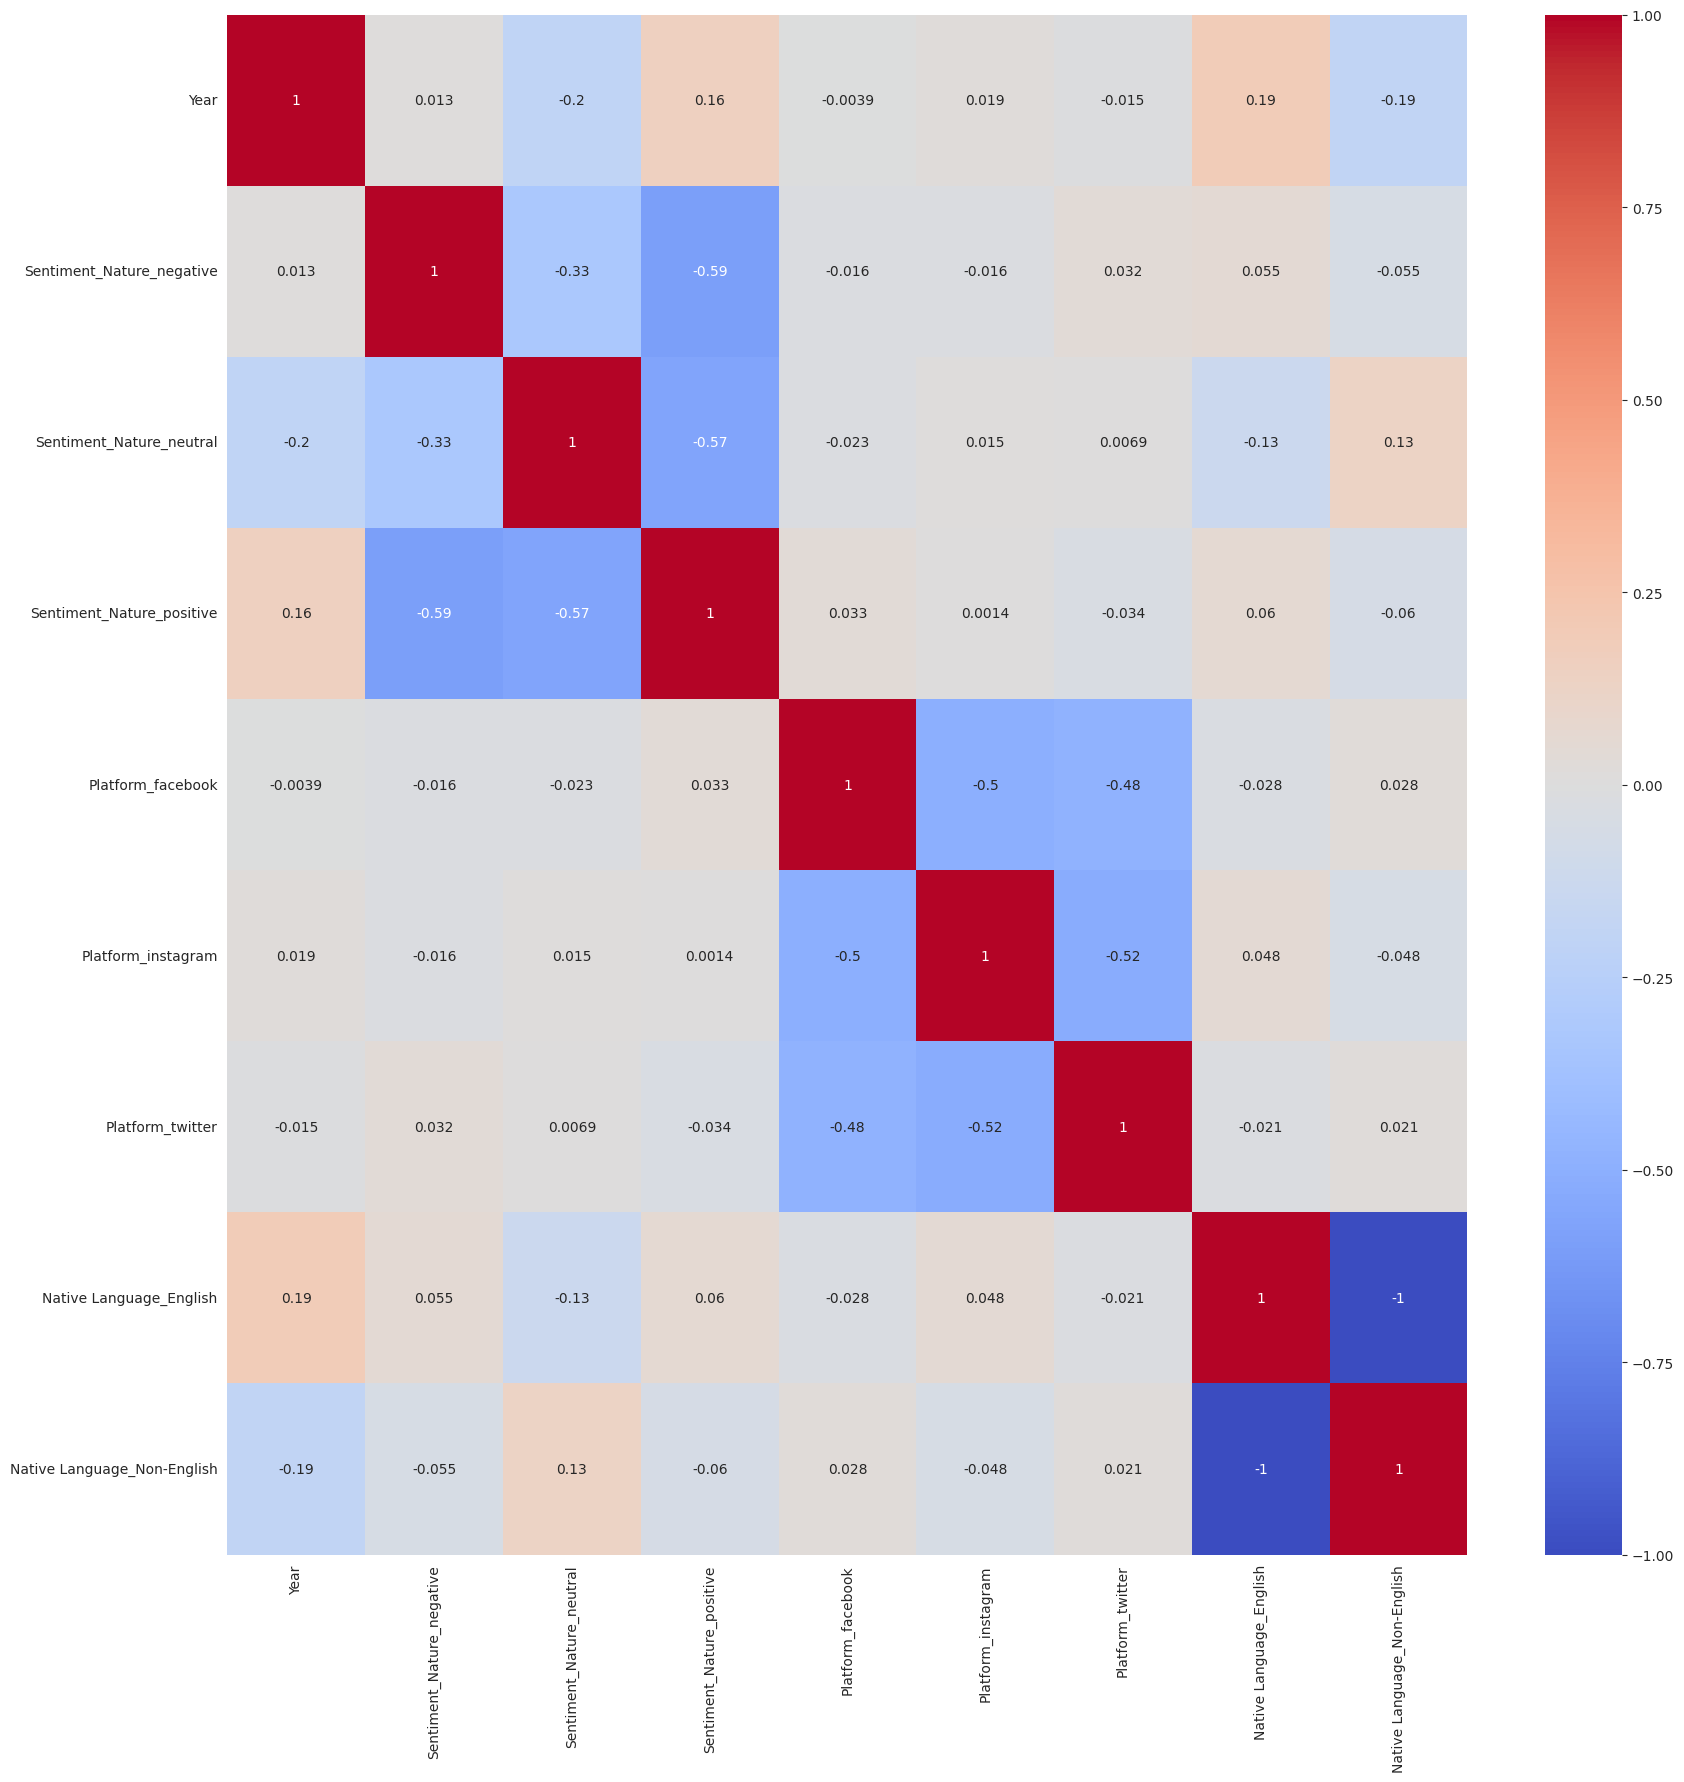

In [ ]:
# visualize the correlation matrix using heatmap
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix_1, cmap='coolwarm', annot=True)
plt.savefig('/kaggle/working/correlation_on_sentiments_to_other_impact.png')

Based on the correlation analysis, it is interesting to see:
1. *Positive* posts are more time-sensitive, and becoming more positive over the year.
2. *Neutral* posts are more language-sensitive, where **non-English speaker** tend to write neutral posts, which might be due to the language barrier, or mislabeling in sentiments.
3. On the other hand, *negative* posts are more language-sensitive, in terms of having **English speaker** writing negiva posts, which might be due to the tendency to express negative feelings in native language.

### Sentiment Correltion with Retweets & Likes

In [ ]:
# create a correlation matrix for sentiment natures and reposts & likes
trim_data_2 = df4[['Sentiment_Nature', 'Retweets', 'Likes']]
dummy_data_2 = pd.get_dummies(data=trim_data_2)
corr_matrix_2 = dummy_data_2.corr()

pd.set_option('display.max_rows', None)
print("\033[1mPositive Sentiment Correlation:\033[0m")
print(f"{corr_matrix_2['Sentiment_Nature_positive'].sort_values(ascending=False)}\n")
print("\033[1mNeutral Sentiment Correlation:\033[0m")
print(f"{corr_matrix_2['Sentiment_Nature_neutral'].sort_values(ascending=False)}\n")
print("\033[1mNegative Sentiment Correlation:\033[0m")
print(f"{corr_matrix_2['Sentiment_Nature_negative'].sort_values(ascending=False)}")

Positive Sentiment Correlation:
Sentiment_Nature_positive    1.000000
Retweets                     0.208841
Likes                        0.206684
Sentiment_Nature_neutral    -0.565775
Sentiment_Nature_negative   -0.594289
Name: Sentiment_Nature_positive, dtype: float64

Neutral Sentiment Correlation:
Sentiment_Nature_neutral     1.000000
Likes                        0.109842
Retweets                     0.108669
Sentiment_Nature_negative   -0.326920
Sentiment_Nature_positive   -0.565775
Name: Sentiment_Nature_neutral, dtype: float64

Negative Sentiment Correlation:
Sentiment_Nature_negative    1.000000
Sentiment_Nature_neutral    -0.326920
Likes                       -0.344023
Retweets                    -0.345352
Sentiment_Nature_positive   -0.594289
Name: Sentiment_Nature_negative, dtype: float64


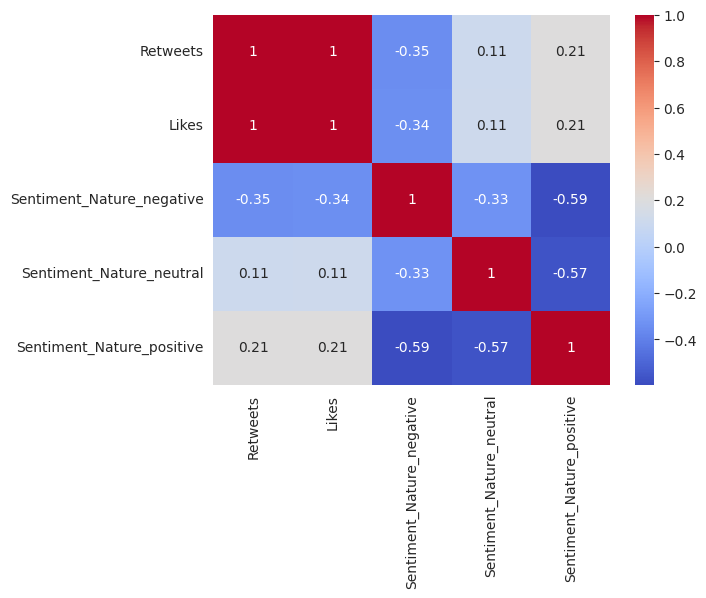

In [ ]:
sns.heatmap(corr_matrix_2, cmap='coolwarm', annot=True)
plt.savefig('/kaggle/working/correlation_on_sentiments_to_retweets_and_likes.png')

Based on the correlation analysis, it is interesting to see:
<br>
1. *Positive* posts tend to get more retweets and likes, which validate our hypothesis.
2. *Neutral* posts have tend to get less retweets and likes, but they are still positively correlated.
3. *Negative* posts shows all negative coorelation, which shows that negative posts do not tend to get more likes and retweets.

In [ ]:
torch.save(model.state_dict(), 'best_model_state.bin')

In [ ]:
import joblib

tokenizer.save_pretrained('bert_tokenizer')
joblib.dump(le, 'label_encoder.pkl')


['label_encoder.pkl']

In [ ]:
from flask import Flask, request, jsonify
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import joblib
import os

# Config
MODEL_NAME = "bert-base-uncased"  # or your actual pretrained model name
NUM_CLASSES = 42  # adjust to your model

# Load tokenizer and label encoder
tokenizer = AutoTokenizer.from_pretrained("bert_tokenizer")
label_encoder = joblib.load("label_encoder.pkl")

# Define the same model class
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        logits = outputs[0]
        cls_output = logits[:, 0, :]  # CLS token
        return self.out(self.drop(cls_output))

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(NUM_CLASSES)
# Load the correct state_dict file
model.load_state_dict(torch.load("best_model_state.bin", map_location=device))
model = model.eval().to(device)

# Create Flask app
app = Flask(__name__)

@app.route("/predict", methods=["POST"])
def predict():
    data = request.get_json()
    if not data or "text" not in data:
        return jsonify({"error": "Missing 'text' field"}), 400

    text = data["text"]
    encoding = tokenizer.encode_plus(
        text,
        max_length=128,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        pred = torch.argmax(probs, dim=1).cpu().numpy()[0]
        sentiment = label_encoder.inverse_transform([pred])[0]

    return jsonify({
        "text": text,
        "predicted_sentiment": sentiment
    })

if __name__ == "__main__":
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
